In [1]:
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

# Load the TensorBoard notebook extension
%load_ext tensorboard

import datetime

from cifar10_preprocessing import get_cifar10_data

In [2]:
X_train, y_train, X_val, y_val, X_test, y_test, label_names = get_cifar10_data(10000, seed=1)


automobile


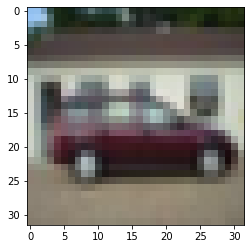

In [22]:
print(label_names[y_train[157]])
plt.imshow(X_train[157])
plt.show()

In [5]:
class ConvNetClassifier(keras.Model):
    """Wrapper para la clase Model de keras. Genera una red convoluciona con filtros de 3x3.

    Esta red se utiliza específicamente para clasificar el dataset CIFAR10. La arquitectura de la red se
    limita a bloques compuestos por capas convoluciones de 3x3 seguidas de Batch Normalization y una capa de max
    pooling de 2x2 con stride de 2x2. Luego de estos bloques se encuentra una capa fully connected de 50 unidades
    y una capa de Dropout con probabilidad 0.2. Finalmente, una última capa fully connected de 10 unidades con
    activación softmax se utiliza para clasificar las imágenes. A excepción de la última capa, todas las demás
    capas utilizan una función de activación reLu.

    Attributes
    ----------
    input_shape : int
        Dimensión de la capa de entrada de la red.
    layers_ : list(keras.layers)
        Lista con todas las capas de la red.
    optimizer : optimizer o str
        Optimizador para la retropropagación.
    loss : loss o str o None
        Función de pérdidas usada para la retropropagación.
    metrics_ : list(metrics o str) o None
        Métricas adicionales para la medición del rendimiento.
    callbacks : list(callbacks) or None.
        Callbacks usados por el modelo.
    epochs : int
        Cantidad de épocas durante el entrenamiento.
    """

    def __init__(
        self,
        input_shape,
        blocks,
        optimizer="rmsprop",
        loss=None,
        metrics=None,
        callbacks=None,
        epochs=1,
        compiled=False
        ):
        """Define los atributos del modelo.

        Parameters
        ----------
        input_shape : int
            Dimensión de la capa de entrada de la red.
        blocks : list(tuple(int, int))
            Lista con los bloques de la red convolucional. Cada tupla contiene 2 enteros, el primero
            indica la cantidad de capas convolucionales por bloque, y el segundo la cantidad de
            filtros en cada capa convolucional. Un bloque se compone de las capas convolucionales
            entregadas por este parámetro seguidas de BatchNorm y un max pooling de 2x2 con stride de 2x2.
        optimizer : optimizer o str, optional
            Optimizador para la retropropagación, por defecto es "rmsprop".
        loss : loss o str o None, optional
            Función de pérdidas usada para la retropropagación, por defecto es None.
        metrics : list(metrics o str) o None, optional
            Métricas adicionales para la medición del rendimiento, por defecto es None.
        callbacks : list(callbacks) or None, optional
            Callbacks usados durante el entrenamiento, por defecto es None.
        epochs : int, optional
            Cantidad de épocas durante el entrenamiento, por defecto es 1.
        compiled : bool, optional
            En caso de ser verdadero, se entrega el modelo compilado, mientras que
            de ser False el modelo se entrega sin compilar, por defecto es False.
        """

        super().__init__()

        self.input_shape_ = input_shape
        self.layers_ = self._add_layers(blocks)
        self.optimizer = optimizer
        self.loss = loss
        self.metrics_ = metrics
        self.callbacks = callbacks
        self.epochs = epochs

        if compiled:
            self.compile_model(optimizer=optimizer, loss=loss, metrics=metrics)
        
    
    def _add_layers(self, blocks):
        """Crea las capas usadas por el modelo.

        Parameters
        ----------
        blocks : list(tuple(int,int))
            Lista con los bloques de la red convolucional. Cada tupla contiene 2 enteros, el primero
            indica la cantidad de capas convolucionales por bloque, y el segundo la cantidad de
            filtros en cada capa convolucional. Un bloque se compone de las capas convolucionales
            entregadas por este parámetro seguidas de BatchNorm y un max pooling de 2x2 con stride de 2x2.

        Returns
        -------
        layers : list(layers)
            Capas de la red neuronal.
        """

        num_blocks = len(blocks)
        layers = []

        # Primero se agrega la capa de entrada
        layers.append(keras.layers.InputLayer((self.input_shape_)))
        layers.append(keras.layers.BatchNormalization())

        # Se generan las capas ocultas
        for i in range(num_blocks):
            for j in range(blocks[i][0]):
                layers.append(keras.layers.Conv2D(
                    filters=blocks[i][1], kernel_size=3, activation="relu"))
                layers.append(keras.layers.BatchNormalization())
            layers.append(keras.layers.MaxPool2D())

        layers.append(keras.layers.Flatten())
        layers.append(keras.layers.Dense(50, activation="relu"))
        layers.append(keras.layers.Dropout(0.2))
        layers.append(keras.layers.Dense(10, activation="softmax"))

        return layers

    def _get_logits(self, inputs, training=False):
        """Entrega los logits luego de un paso forward.

        Parameters
        ----------
        inputs : np.array o tf.tensor
            Datos de entrenamiento.
        training : bool, optional
            Indica si debe haber entrenamiento o no, por defecto es False.

        Returns
        -------
        x : tf.tensor
            logits de los datos de entrenamiento.
        """
        x = inputs
        for i in range(len(self.layers_) - 1):
            if self.layers_[i].name.startswith("Dropout"):
                x = self.layers_[i](x, training)
            else:
                x = self.layers_[i](x)

        return x

    def call(self, inputs, training=False, logits=False):
        """Llama al modelo con los datos de inputs y entrega un tensor con las predicciones.

        Parameters
        ----------
        inputs : np.array o tf.tensor
            Datos de entrenamiento.
        training : bool, optional
            Indica si debe haber entrenamiento o no, por defecto es False.
        logits : bool, optional
            Indica si el modelo retorna los logits o las probabilidades, por defecto es False.

        Returns
        -------
        [type]
            [description]
        """
        x = self._get_logits(inputs, training)

        # Si el flag está activado, se retornan los logits.
        if logits:
            return x
        
        # En caso de no necesitar los logits, se pasan los datos por la capa de salida para obtener
        # las probabilidades de cada clase.
        return self.layers_[-1](x)


    def compile_model(self, **kwargs):
        """Compila el modelo para el entrenamiento.

        Para entrenar el modelo se requiere de un optimizador que obtenga el gradiente y
        lo utilice para modificar las variables entrenables; una función de pérdidas (loss)
        que mida la error de predicción; y opcionalmente una lista de métricas que permiten
        medir el desempeño del modelo. Cualquier otro argumento entregado arroja un TypeError.

        En caso de encontrar algún argumento soportado por el método, éste se asigna al parámetro
        correspondiente del modelo. Finalmente se compila el modelo con los parámetros que éste posea.

        Parameters
        ----------
        **kwargs
            Cantidad variable de parámetros. El método sólo busca los parámetros "optimizer",
            "loss" y "metrics". Cualquier otro parámetro levanta una excepción.

        Raises
        -------
        TypeError
            Si se entrega algún parámetro distinto a los soportados.
        """


        self.optimizer = kwargs.pop("optimizer", None) if kwargs.get("optimizer") else self.optimizer
        self.loss = kwargs.pop("loss", None) if kwargs.get("loss") else self.loss
        self.metrics_ = kwargs.pop("metrics", None) if kwargs.get("metrics") else self.metrics_

        # Si después de obtener los argumentos soportados siguen habiendo otros argumentos,
        # se levanta una excepción.
        if len(kwargs) > 0:
            raise TypeError(
                """got unexpected keyword argument: only 'optimizer', 'loss' and
                'metrics' are accepted keywords arguments.""")

        return super().compile(
            optimizer=self.optimizer,
            loss=self.loss,
            metrics=self.metrics_
        )


    def fit(self, x=None, y=None, batch_size=None, verbose='auto', validation_data=None):
        """ Entrena el modelo por una cantidad fija de épocas.

        Parameters
        ----------
        x : np.array o tf.tensor
            Datos de entrenamiento
        y : np.array o tf.tensor
            Etiquetas de los datos. El tipo de y debe ser consistente con el tipo de x.
        batch_size : int o None
            Número de ejemplos por actualización del gradiente. Si no se especifica,
            por defecto es 32.
        verbose : 'auto', 0, 1 o 2, optional
            Modo de verbosidad. 0 = silencioso, 1 = barra de progreso, 2 = una línea por época.
            'auto' es por defecto 1 en la mayoría de lo casos.
        validation_data : tuple(np.array) o tuple(tf.tensor)
            Datos sobre los que se evaluará la función de pérdidas y cualquier métrica entregada al
            modelo al final de cada época. El modelo nunca entrenará con estos datos. Por lo tanto,
            se debe notar el hecho de que la validación no se ve afectada por capas de regularización
            como por ejemplo capas de Dropout.
            
        Returns
        -------
        history : History
            Un objeto History. El atributo History.history es un record de las pérdidas y métricas,
            tanto de entrenamiento como validación (en caso de entregar validation_data) en cada época.

        Raises
        -------
        RuntimeError
            Si el modelo no ha sido compilado
        ValueError
            En caso de no coincidir el tipo de los datos con lo que espera el modelo, o cuando
            los datos de entrada están vacios.
        """
        return super().fit(
            x, y, batch_size=batch_size, epochs=self.epochs, verbose=verbose,
            callbacks=self.callbacks, validation_data=validation_data)


In [6]:
sgd_optimizer = keras.optimizers.SGD(learning_rate=0.01, decay=1e-7, momentum=0.9)
loss='sparse_categorical_crossentropy'
metrics=['Accuracy']

# Directorio para guardar logs
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Callbacks utilizados
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, verbose=1)

In [7]:
# Inicialziación del modelo
model = ConvNetClassifier(
    (32, 32, 3),
    [(2, 16), (2, 32)],
    optimizer=sgd_optimizer,
    loss=loss,
    metrics=metrics,
    callbacks=[tensorboard_callback, early_stopping],
    epochs=20,
    compiled=True
    )


In [8]:
# Entrenamiento del modelo
history = model.fit(
    X_train,
    y_train,
    batch_size=80,
    verbose=1,
    validation_data=(X_val, y_val),
)


Epoch 1/20
500/500 [==============================] - 97s 190ms/step - loss: 1.5751 - Accuracy: 0.4331 - val_loss: 1.3287 - val_Accuracy: 0.5179
Epoch 2/20
500/500 [==============================] - 92s 185ms/step - loss: 1.1906 - Accuracy: 0.5748 - val_loss: 1.0528 - val_Accuracy: 0.6308
Epoch 3/20
500/500 [==============================] - 95s 189ms/step - loss: 1.0342 - Accuracy: 0.6324 - val_loss: 0.9505 - val_Accuracy: 0.6627
Epoch 4/20
500/500 [==============================] - 90s 181ms/step - loss: 0.9471 - Accuracy: 0.6653 - val_loss: 0.9257 - val_Accuracy: 0.6827
Epoch 5/20
500/500 [==============================] - 94s 188ms/step - loss: 0.8825 - Accuracy: 0.6872 - val_loss: 0.8698 - val_Accuracy: 0.6946
Epoch 6/20
500/500 [==============================] - 94s 188ms/step - loss: 0.8342 - Accuracy: 0.7052 - val_loss: 0.8509 - val_Accuracy: 0.7049
Epoch 7/20
500/500 [==============================] - 103s 207ms/step - loss: 0.7911 - Accuracy: 0.7213 - val_loss: 0.8313 - val_A

In [9]:
train_metrics = model.evaluate(X_train, y_train, batch_size=80)
test_metrics = model.evaluate(X_test, y_test, batch_size=80)

125/125 [==============================] - 1s 12ms/step - loss: 0.8543 - Accuracy: 0.7150


In [10]:
predictions = np.argmax(model.predict(X_test, verbose=0), axis=1)
cm = confusion_matrix(y_test, predictions)

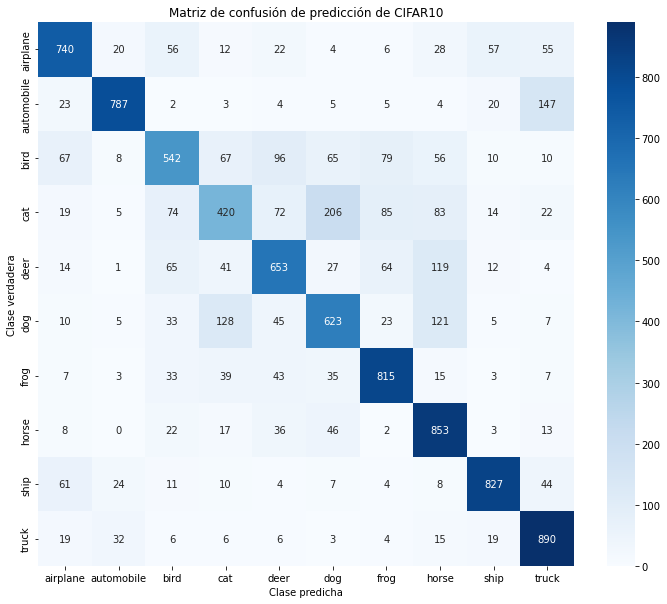

In [13]:
fig, ax = plt.subplots(figsize=(12, 10))
matrix = sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', ax=ax)

matrix.set_xticklabels(label_names)
matrix.set_yticklabels(label_names)
matrix.set_title('Matriz de confusión de predicción de CIFAR10')
matrix.set_xlabel('Clase predicha')
matrix.set_ylabel('Clase verdadera')

plt.show()